In [1]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_lcbench_varying_cost_runs(data, acq):
    runs = api.runs(path="ziv-scully-group/PandoraBayesOpt", filters={
        "sweep": "4fxoyssk",
        "config.dataset_name": data,
        "config.acquisition_function": acq},
        )
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["config id", "cumulative cost", "current best id", "current best observed", "StablePBGI(1e-5) acq", "StablePBGI(1e-6) acq", "StablePBGI(1e-7) acq", "LogEIC acq", "exp min regret gap"]
        history = list(run.scan_history(keys = metric_keys, page_size=1_000_000_000))
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [2]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = ["StablePBGI(1e-5)", "StablePBGI(1e-6)", "StablePBGI(1e-7)", "LogEIC"]

In [3]:
grouped_runs = {(d, a): load_lcbench_varying_cost_runs(d, a) for d in dataset_names for a in acquisition_functions}

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [4]:
from collections import defaultdict

config_id_per_acq = defaultdict(dict)
cumulative_cost_per_acq = defaultdict(dict)
current_best_id_per_acq = defaultdict(dict)
current_best_observed_per_acq = defaultdict(dict)
acq_per_acq = defaultdict(dict)
StablePBGI_1e_5_acq_per_acq = defaultdict(dict)
StablePBGI_1e_6_acq_per_acq = defaultdict(dict)
StablePBGI_1e_7_acq_per_acq = defaultdict(dict)
LogEIC_acq_per_acq = defaultdict(dict)
exp_min_regret_gap_per_acq = defaultdict(dict)

for d in dataset_names:
    for a in acquisition_functions:
        config_and_metrics_per_seed = grouped_runs[(d,a)]

        # Extract metrics along with the seeds for sorting
        seeds_and_metrics = [
            (config['seed'], m['cumulative cost'], m['config id'], m['current best id'], m['current best observed'], m['StablePBGI(1e-5) acq'], m['StablePBGI(1e-6) acq'], m['StablePBGI(1e-7) acq'], m['LogEIC acq'], m['exp min regret gap'])
            for config, m in config_and_metrics_per_seed
            if len(m['current best observed']) > 0
        ]

        # Sort by seed
        seeds_and_metrics.sort(key=lambda x: x[0])

        # Extract sorted metrics
        cumulative_cost_per_seed = np.array([item[1] for item in seeds_and_metrics])
        config_id_per_seed = np.array([item[2] for item in seeds_and_metrics])
        current_best_id_per_seed = np.array([item[3] for item in seeds_and_metrics])
        current_best_observed_per_seed = np.array([item[4] for item in seeds_and_metrics])
        StablePBGI_1e_5_acq_per_seed = np.array([item[5] for item in seeds_and_metrics], dtype=float)
        StablePBGI_1e_6_acq_per_seed = np.array([item[6] for item in seeds_and_metrics], dtype=float)
        StablePBGI_1e_7_acq_per_seed = np.array([item[7] for item in seeds_and_metrics], dtype=float)
        LogEIC_acq_per_seed = np.array([item[8] for item in seeds_and_metrics], dtype=float)
        exp_min_regret_gap_per_seed = np.array([item[9] for item in seeds_and_metrics], dtype=float)

        print(d, a, config_id_per_seed.shape)

        cumulative_cost_per_acq[d][a] = cumulative_cost_per_seed
        config_id_per_acq[d][a] = config_id_per_seed
        current_best_id_per_acq[d][a] = current_best_id_per_seed
        current_best_observed_per_acq[d][a] = current_best_observed_per_seed
        StablePBGI_1e_5_acq_per_acq[d][a] = StablePBGI_1e_5_acq_per_seed
        StablePBGI_1e_6_acq_per_acq[d][a] = StablePBGI_1e_6_acq_per_seed
        StablePBGI_1e_7_acq_per_acq[d][a] = StablePBGI_1e_7_acq_per_seed
        LogEIC_acq_per_acq[d][a] = LogEIC_acq_per_seed
        exp_min_regret_gap_per_acq[d][a] = exp_min_regret_gap_per_seed

Fashion-MNIST StablePBGI(1e-5) (50, 201)
Fashion-MNIST StablePBGI(1e-6) (50, 201)
Fashion-MNIST StablePBGI(1e-7) (50, 201)
Fashion-MNIST LogEIC (50, 201)
adult StablePBGI(1e-5) (50, 201)
adult StablePBGI(1e-6) (50, 201)
adult StablePBGI(1e-7) (50, 201)
adult LogEIC (50, 201)
higgs StablePBGI(1e-5) (50, 201)
higgs StablePBGI(1e-6) (50, 201)
higgs StablePBGI(1e-7) (50, 201)
higgs LogEIC (50, 201)
volkert StablePBGI(1e-5) (50, 201)
volkert StablePBGI(1e-6) (50, 201)
volkert StablePBGI(1e-7) (50, 201)
volkert LogEIC (50, 201)


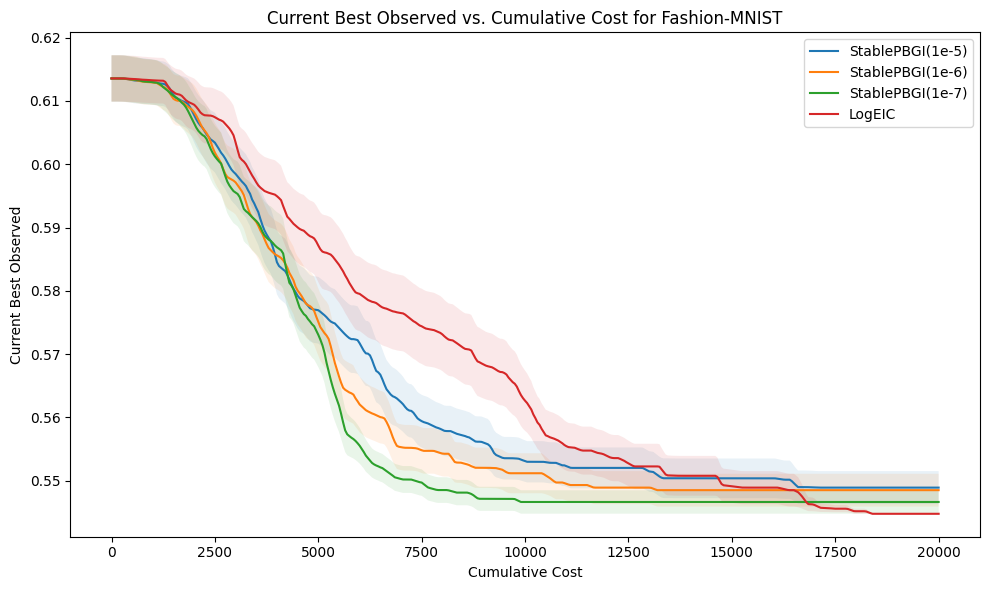

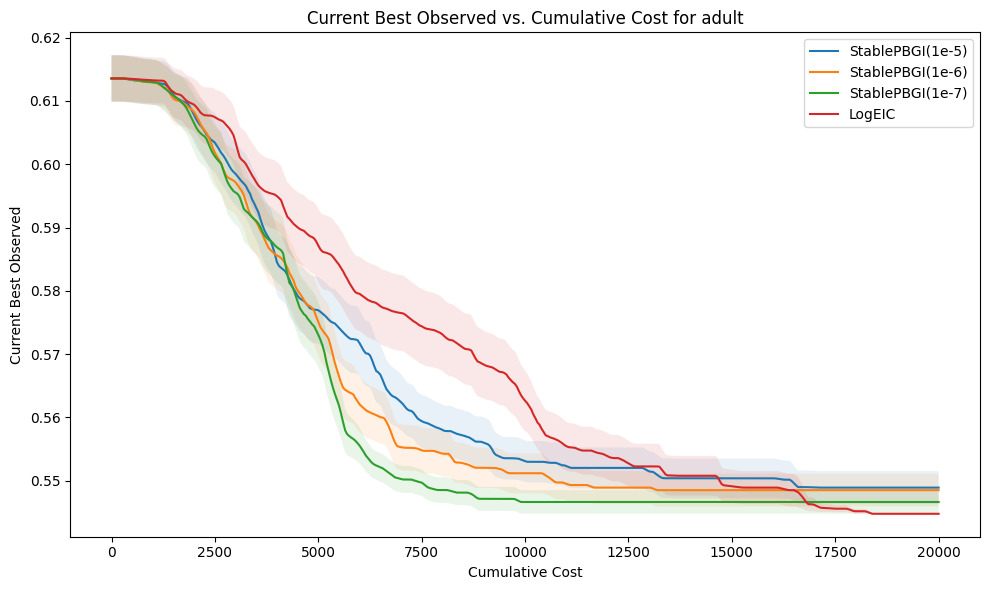

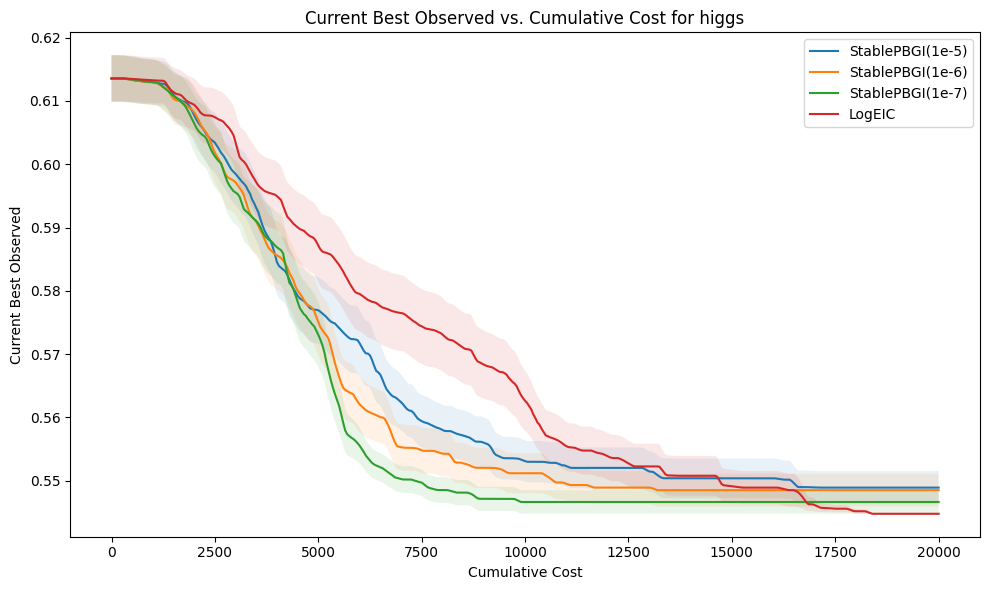

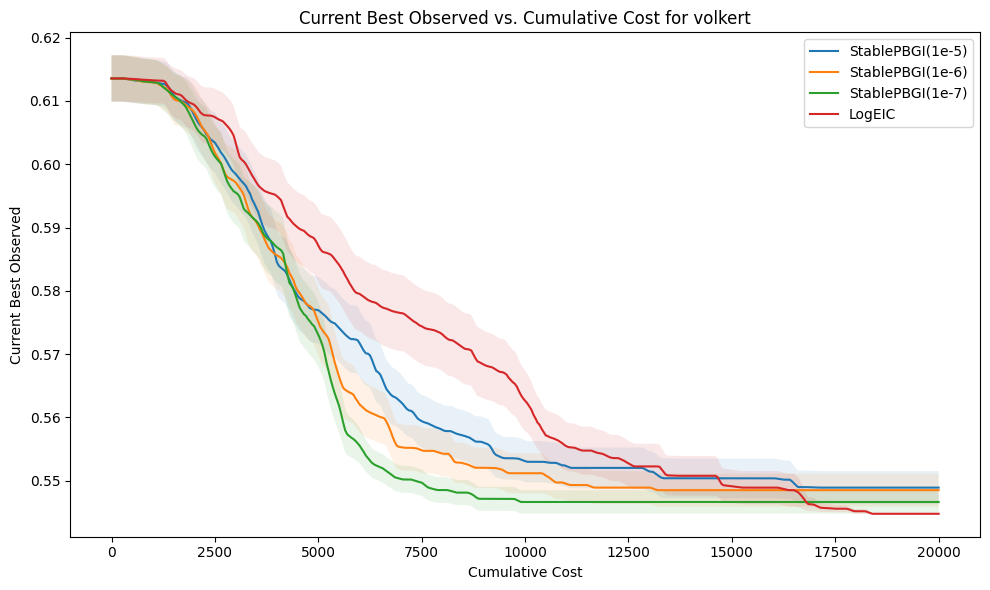

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
# Adjust the number of grid points as needed (here, we use 401 points).
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions:
        # List to hold interpolated curves for each seed
        interpolated_curves = []
        
        # Loop over each seed (assume the first dimension indexes seeds)
        for seed_id in range(len(cumulative_cost_per_acq[d][a])):
            # Get the seed's cumulative cost and current best observed arrays.
            cum_cost = np.array(cumulative_cost_per_acq[d][a][seed_id])
            best_obs = np.array(current_best_observed_per_acq[d][a][seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            best_obs_sorted = best_obs[sort_id]
            
            # Use interpolation to compute the best observed at the common cost_grid.
            # np.interp assumes the x-values (cum_cost_sorted) are increasing.
            interp_best_obs = np.interp(cost_grid, cum_cost_sorted, best_obs_sorted)
            interpolated_curves.append(interp_best_obs)
        
        # Convert to a NumPy array with shape (n_seeds, len(cost_grid))
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute the mean and standard error across seeds at each grid point.
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot the mean curve and the shaded area for standard error.
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize the plot.
    plt.title(f"Current Best Observed vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
%%capture
from pprint import pprint
from LCBench.api import Benchmark
import os

os.makedirs("LCBench/cached", exist_ok=True)
bench_dir = "LCBench/cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

In [7]:
from collections import defaultdict
import numpy as np

# Initialize dictionaries to hold the per-iteration test metrics for each dataset and acquisition function.
test_cross_entropy_per_acq = defaultdict(dict)
test_accuracy_per_acq = defaultdict(dict)

# Loop over each dataset and acquisition function.
for d in dataset_names:
    for a in acquisition_functions:
        # current_best_id_per_acq[d][a] is assumed to be a 2D array with shape (n_seeds, n_iterations)
        best_ids = current_best_id_per_acq[d][a]
        n_seeds, n_iterations = best_ids.shape
        
        # Prepare arrays to store the test metrics for each seed and each iteration.
        test_ce_mat = np.empty((n_seeds, n_iterations))
        test_acc_mat = np.empty((n_seeds, n_iterations))
        
        # Use the precomputed best configuration IDs to query test metrics.
        for s in range(n_seeds):
            for i in range(n_iterations):
                config_id = best_ids[s, i]
                test_ce_mat[s, i] = bench.query(d, "final_test_cross_entropy", config_id)
                test_acc_mat[s, i] = bench.query(d, "final_test_accuracy", config_id)
        
        # Store the resulting matrices in the dictionaries.
        test_cross_entropy_per_acq[d][a] = test_ce_mat
        test_accuracy_per_acq[d][a] = test_acc_mat

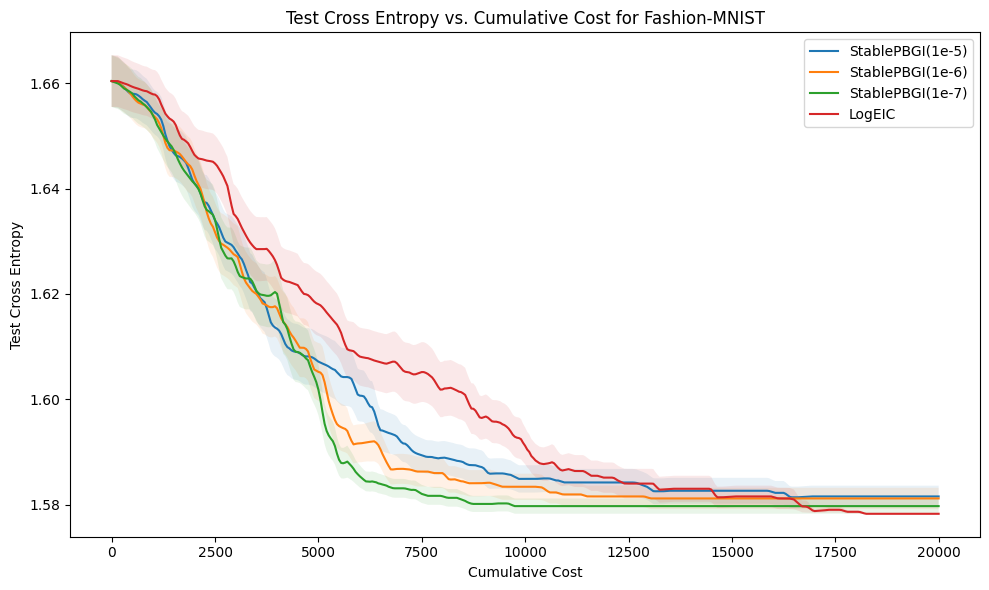

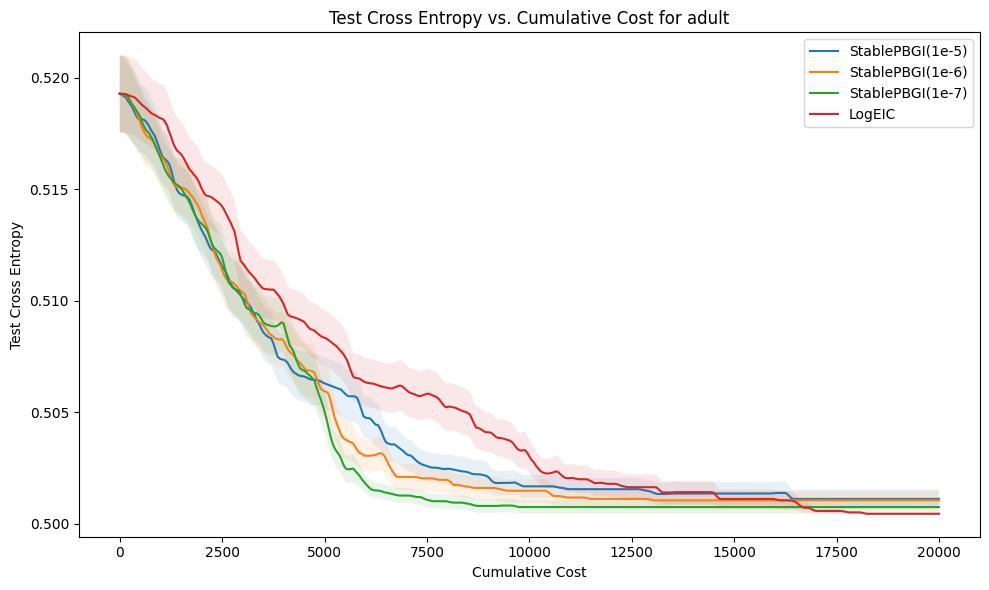

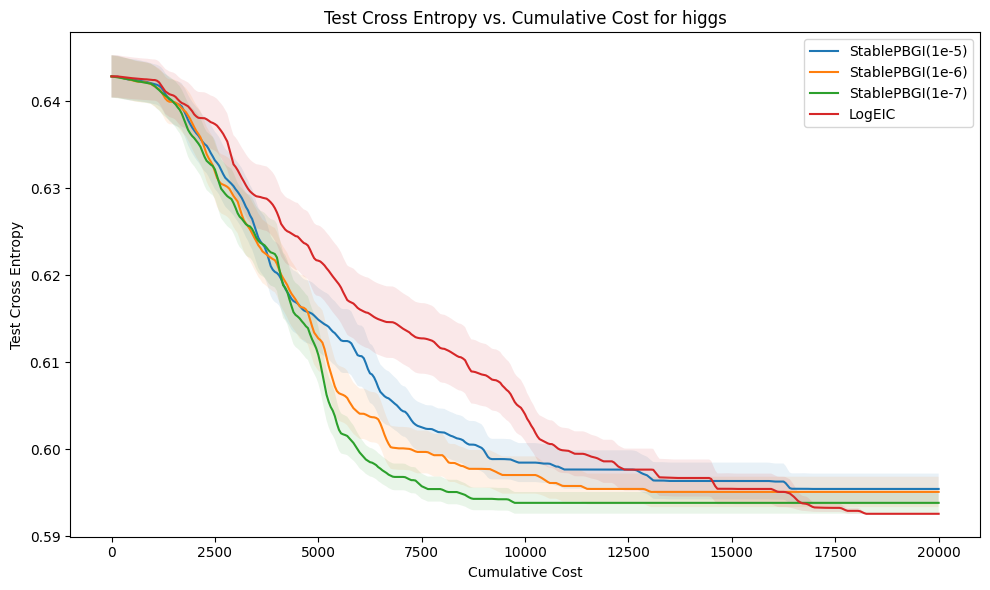

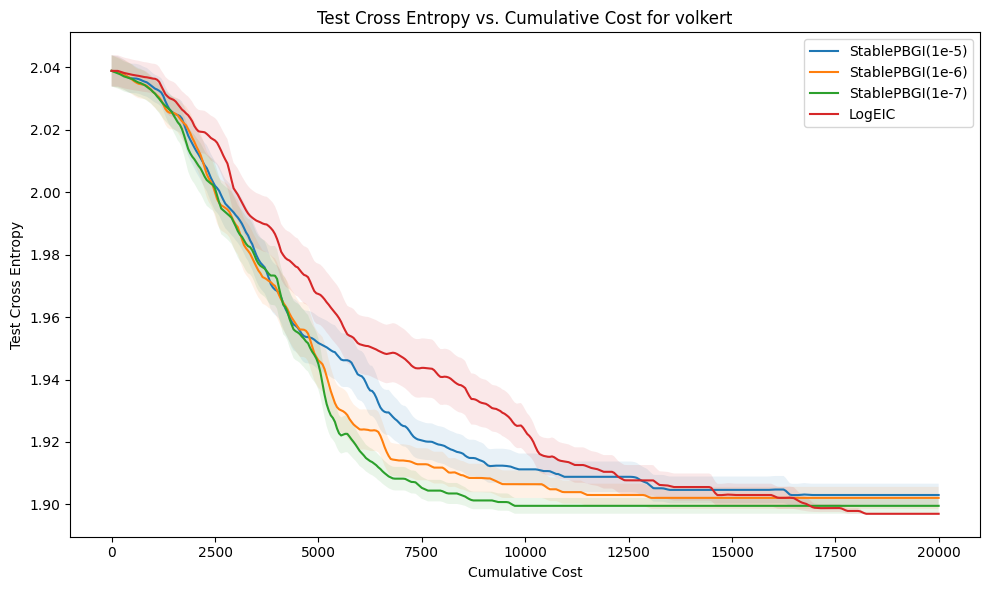

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions:
        # List to hold interpolated curves for each seed.
        interpolated_curves = []
        
        # Loop over each seed (assuming the first dimension indexes seeds).
        for seed_id in range(len(cumulative_cost_per_acq[d][a])):
            # Get the seed's cumulative cost and test cross entropy arrays.
            cum_cost = np.array(cumulative_cost_per_acq[d][a][seed_id])
            test_ce = np.array(test_cross_entropy_per_acq[d][a][seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            test_ce_sorted = test_ce[sort_id]
            
            # Use interpolation to compute test cross entropy at the common cost_grid.
            interp_test_ce = np.interp(cost_grid, cum_cost_sorted, test_ce_sorted)
            interpolated_curves.append(interp_test_ce)
        
        # Convert the list to a NumPy array (shape: [n_seeds, len(cost_grid)]).
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute the mean and standard error (std/sqrt(n_seeds)) across seeds.
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot the mean curve with a shaded standard error region.
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize the plot.
    plt.title(f"Test Cross Entropy vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Test Cross Entropy")
    plt.legend()
    plt.tight_layout()
    plt.show()

[Fashion-MNIST] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


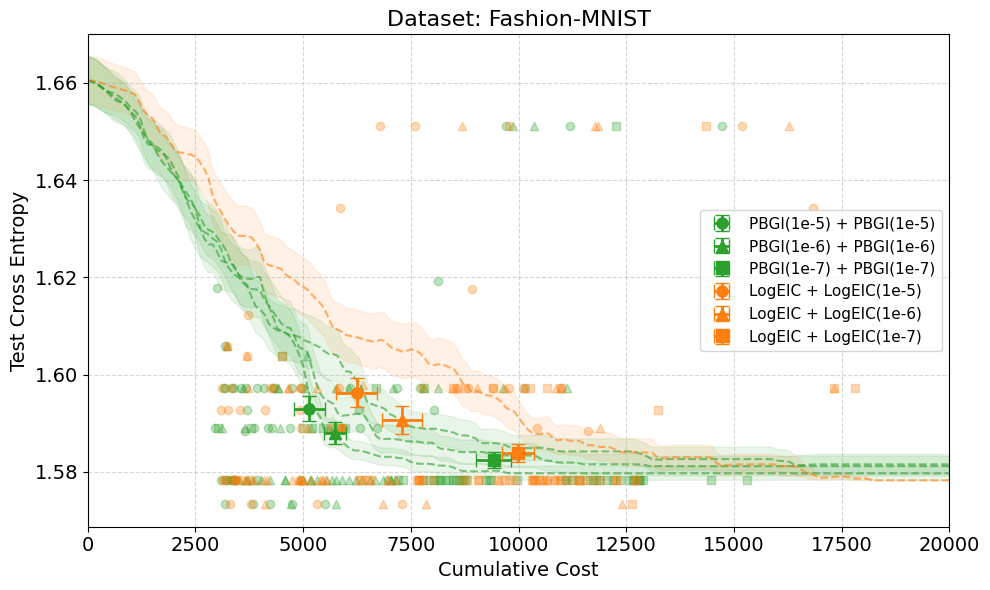

[adult] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[adult] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[adult] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


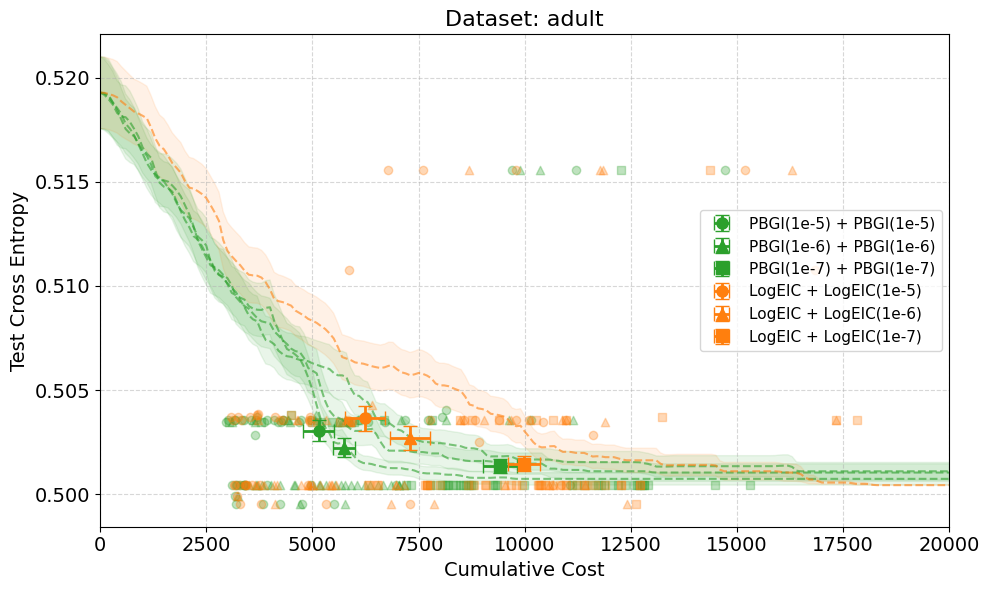

[higgs] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[higgs] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[higgs] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


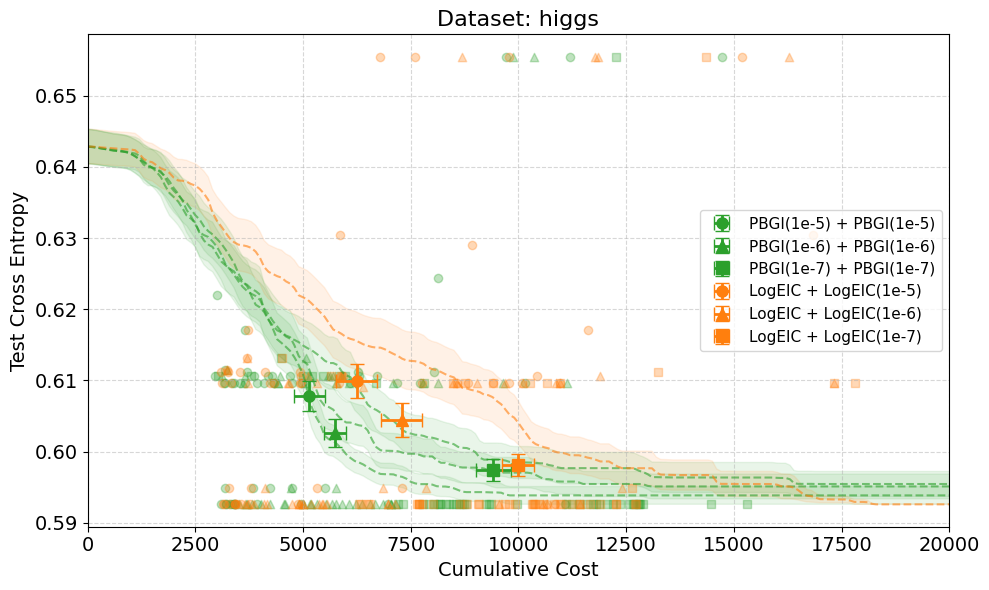

[volkert] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[volkert] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[volkert] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


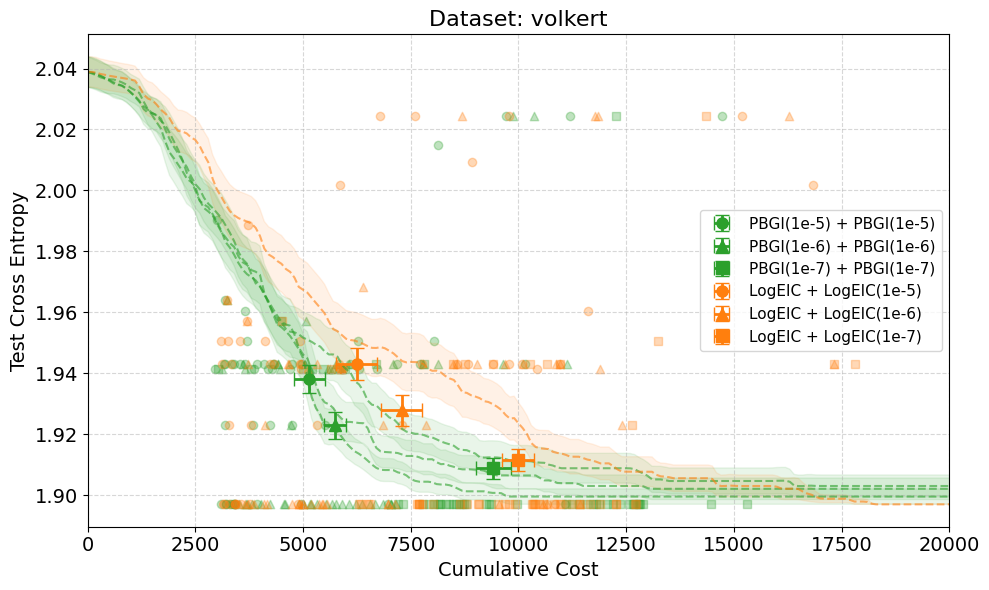

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define tab colors for each stopping rule type:
color_dict = {
    'StablePBGI': 'tab:green',
    'LogEIC': 'tab:orange',
}

# Marker styles by parameter:
marker_dict = {
    '1e-5': 'o',     # circle
    '1e-6': '^',     # triangle
    '1e-7': 's',     # square
}

# Updated rules with structured labels:
stopping_rules = [
    # PBGI rules:
    {'label': 'PBGI(1e-5) + PBGI(1e-5)', 'acq_key': 'StablePBGI(1e-5)', 'color': color_dict['StablePBGI'], 'marker': marker_dict['1e-5'],
     'condition_fn': lambda i, seed_id, d: (
         StablePBGI_1e_5_acq_per_acq[d]['StablePBGI(1e-5)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['StablePBGI(1e-5)'][seed_id][i-1])},
    {'label': 'PBGI(1e-6) + PBGI(1e-6)', 'acq_key': 'StablePBGI(1e-6)', 'color': color_dict['StablePBGI'], 'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         StablePBGI_1e_6_acq_per_acq[d]['StablePBGI(1e-6)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['StablePBGI(1e-6)'][seed_id][i-1])},
    {'label': 'PBGI(1e-7) + PBGI(1e-7)', 'acq_key': 'StablePBGI(1e-7)', 'color': color_dict['StablePBGI'], 'marker': marker_dict['1e-7'],
     'condition_fn': lambda i, seed_id, d: (
         StablePBGI_1e_7_acq_per_acq[d]['StablePBGI(1e-7)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['StablePBGI(1e-7)'][seed_id][i-1])},
    

    # LogEIC rules:
    {'label': 'LogEIC + LogEIC(1e-5)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-5'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-5))},
    {'label': 'LogEIC + LogEIC(1e-6)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-6))},
    {'label': 'LogEIC + LogEIC(1e-7)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-7'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-7))},
]

# Define cost grid for interpolation
cost_grid = np.linspace(0, 80000, 801)

# Plotting loop for each dataset
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    plotted_curves = set()

    # Set x-axis limit based on dataset
    if d == "Fashion-MNIST":
        x_limit = 20000
    elif d == "adult":
        x_limit = 20000
    elif d == "higgs":
        x_limit = 20000
    elif d == "volkert":
        x_limit = 20000
    else:
        x_limit = 80000  # default if dataset is not one of the above

    for rule in stopping_rules:
        acq_key = rule['acq_key']
        color = rule['color']
        label = rule['label']
        marker = rule['marker']

        # Plot acquisition curve if not yet shown
        if acq_key not in plotted_curves:
            interpolated_curves = []
            for seed_id in range(len(test_cross_entropy_per_acq[d][acq_key])):
                cost_arr = np.array(cumulative_cost_per_acq[d][acq_key][seed_id])
                ce_arr = np.array(test_cross_entropy_per_acq[d][acq_key][seed_id])
                sort_idx = np.argsort(cost_arr)
                cost_sorted = cost_arr[sort_idx]
                ce_sorted = ce_arr[sort_idx]
                interp_ce = np.interp(cost_grid, cost_sorted, ce_sorted)
                interpolated_curves.append(interp_ce)
            interpolated_curves = np.array(interpolated_curves)
            mean_ce = np.mean(interpolated_curves, axis=0)
            sem_ce = np.std(interpolated_curves, axis=0) / np.sqrt(len(interpolated_curves))
            plt.plot(cost_grid, mean_ce, linestyle='--', color=color, alpha=0.6)
            plt.fill_between(cost_grid, mean_ce - sem_ce, mean_ce + sem_ce, color=color, alpha=0.1)
            plotted_curves.add(acq_key)

        # Stopping point logic: check condition only after 20 iterations
        stop_costs, stop_test_ce = [], []
        no_stop_count = 0
        n_seeds = len(test_cross_entropy_per_acq[d][acq_key])
        for seed_id in range(n_seeds):
            test_ce_arr = test_cross_entropy_per_acq[d][acq_key][seed_id]
            cost_arr = cumulative_cost_per_acq[d][acq_key][seed_id]
            if len(test_ce_arr) < 20:
                # Not enough iterations to start checking the condition
                stop_id = len(test_ce_arr) - 1
            else:
                stop_id = next(
                    (i for i in range(20, len(test_ce_arr)) if rule['condition_fn'](i, seed_id, d)),
                    len(test_ce_arr) - 1  # default: last iteration if condition never met
                )
            if stop_id == len(test_ce_arr) - 1:
                no_stop_count += 1
            stop_costs.append(cost_arr[stop_id])
            stop_test_ce.append(test_ce_arr[stop_id])

        # Print number of no-stops
        print(f"[{d}] {label} — No-stop count: {no_stop_count} / {n_seeds}")

        if stop_costs:
            stop_costs = np.array(stop_costs)
            stop_test_ce = np.array(stop_test_ce)
            plt.scatter(stop_costs, stop_test_ce, color=color, alpha=0.3, marker=marker)

            mx, my = np.mean(stop_costs), np.mean(stop_test_ce)
            sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
            sy = np.std(stop_test_ce) / np.sqrt(len(stop_test_ce))
            plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=marker, color=color,
                         markersize=8, capsize=5, linewidth=2, label=label)

    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test Cross Entropy", fontsize=14)
    plt.xlim(0, x_limit)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dataset: {d}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

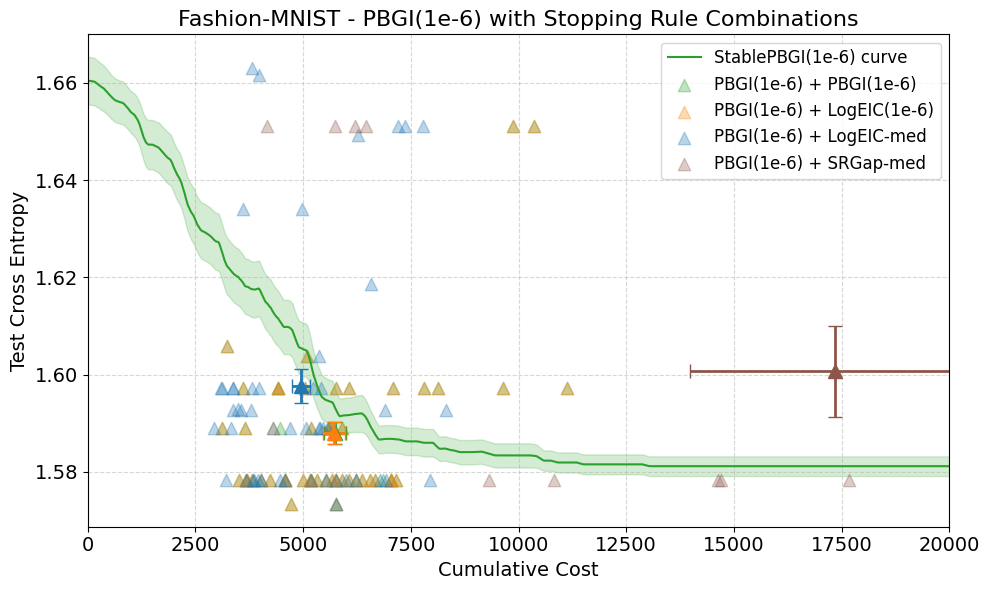

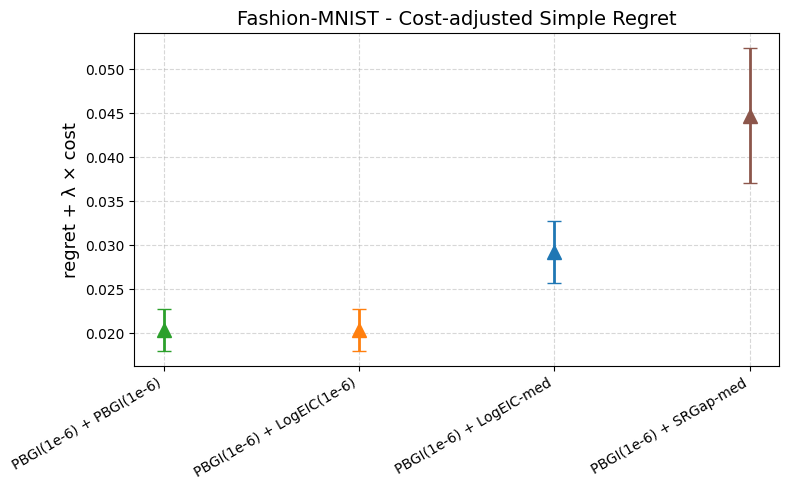

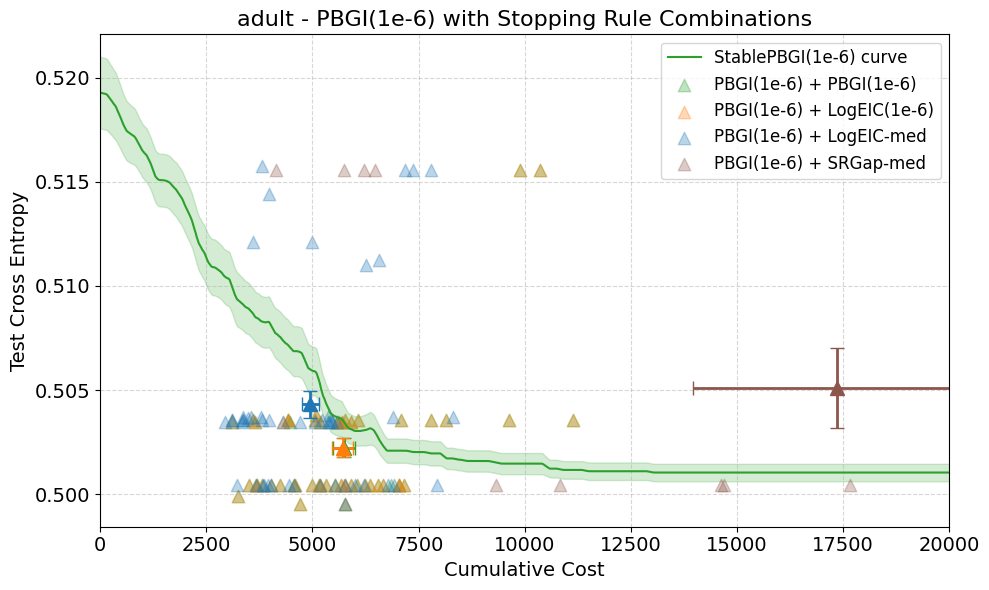

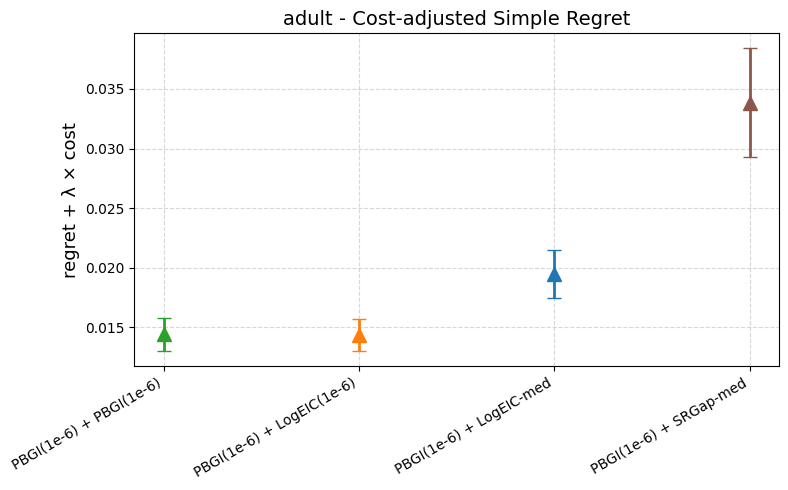

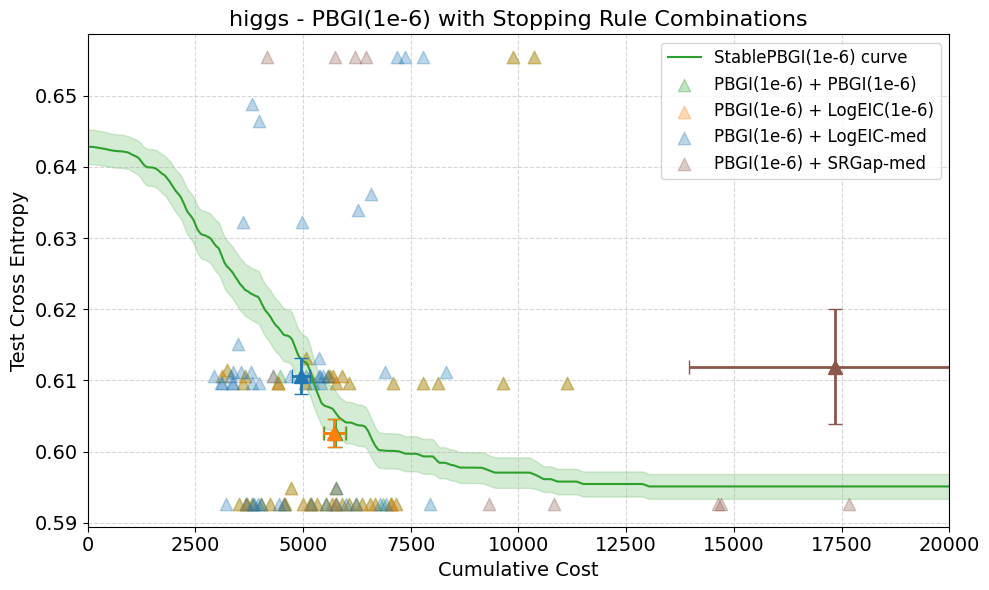

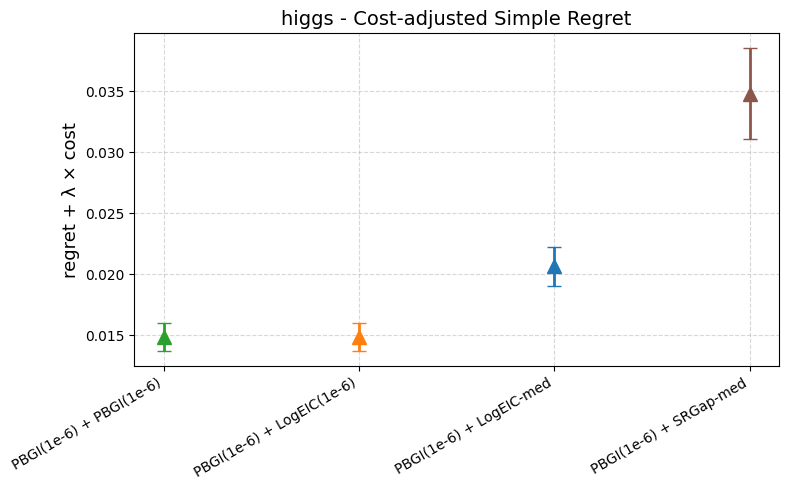

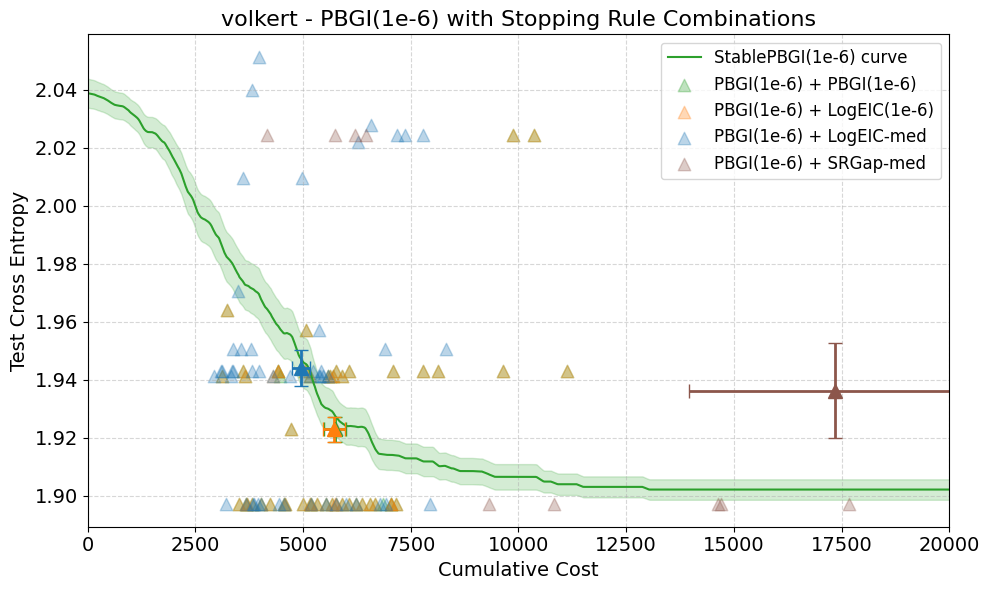

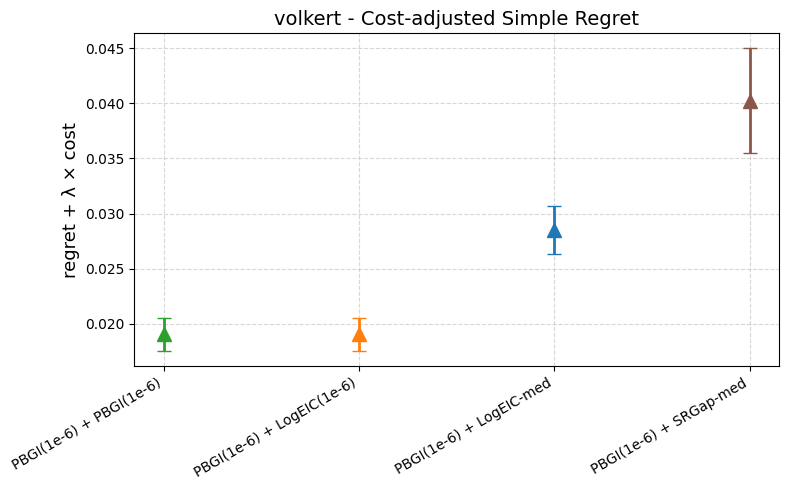

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define tab colors for each stopping rule type:
color_dict = {
    'PBGI': 'tab:green',
    'LogEIC': 'tab:orange',
    'LogEIC-med': 'tab:blue',
    'SRGap-med': 'tab:brown'
}

# Marker styles by parameter:
marker_dict = {
    '1e-6': '^',     # triangle
}

# Define the stopping rules with 20-iteration delay
stopping_rules = [
    {'label': 'PBGI(1e-6) + PBGI(1e-6)', 
     'acq_key': 'StablePBGI(1e-6)', 
     'color': color_dict['PBGI'], 
     'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         i >= 20 and StablePBGI_1e_6_acq_per_acq[d]['StablePBGI(1e-6)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['StablePBGI(1e-6)'][seed_id][i-1])
    },

    {'label': 'PBGI(1e-6) + LogEIC(1e-6)', 
     'acq_key': 'StablePBGI(1e-6)', 
     'color': color_dict['LogEIC'], 
     'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         i >= 20 and LogEIC_acq_per_acq[d]['StablePBGI(1e-6)'][seed_id][i] <= np.log(1e-6))
    },

    {'label': 'PBGI(1e-6) + LogEIC-med', 
     'acq_key': 'StablePBGI(1e-6)', 
     'color': color_dict['LogEIC-med'], 
     'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         i >= 20 and
         LogEIC_acq_per_acq[d]['StablePBGI(1e-6)'][seed_id][i] <
         np.log(0.01) + np.nanmedian(LogEIC_acq_per_acq[d]['StablePBGI(1e-6)'][seed_id][1:21]))
    },

    {'label': 'PBGI(1e-6) + SRGap-med', 
     'acq_key': 'StablePBGI(1e-6)', 
     'color': color_dict['SRGap-med'], 
     'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         i >= 20 and
         exp_min_regret_gap_per_acq[d]['StablePBGI(1e-6)'][seed_id][i] <
         0.1 * np.nanmedian(exp_min_regret_gap_per_acq[d]['StablePBGI(1e-6)'][seed_id][1:21]))
    },
]

# Define the common cumulative cost grid
cost_grid = np.linspace(0, 20000, 801)
fixed_acq = "StablePBGI(1e-6)"
lmbda = 1e-6

# Initialize containers
stopping_counts = {rule['label']: 0 for rule in stopping_rules}
stop_disutilities = {rule['label']: [] for rule in stopping_rules}

# Loop over each dataset
for d in dataset_names:
    plt.figure(figsize=(10, 6))

    best_test_ce = bench.query_best_final(d, "final_test_cross_entropy", "final_test_cross_entropy", 1999)

    # --- Plot the continuous mean + SEM curve for the baseline ---
    interpolated_curves = []
    for seed_id in range(len(cumulative_cost_per_acq[d][fixed_acq])):
        cum_cost = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        test_ce = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        sort_id = np.argsort(cum_cost)
        cum_cost_sorted = cum_cost[sort_id]
        test_ce_sorted = test_ce[sort_id]
        interp_test_ce = np.interp(cost_grid, cum_cost_sorted, test_ce_sorted)
        interpolated_curves.append(interp_test_ce)
    interpolated_curves = np.array(interpolated_curves)
    mean_curve = np.mean(interpolated_curves, axis=0)
    sem_curve = np.std(interpolated_curves, axis=0) / np.sqrt(interpolated_curves.shape[0])

    plt.plot(cost_grid, mean_curve, label=f"{fixed_acq} curve", color=color_dict['PBGI'])
    plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, color=color_dict['PBGI'], alpha=0.2)

    # --- Overlay markers for stopping rules ---
    for rule in stopping_rules:
        if rule['label'].startswith("PBGI(1e-6)"):
            stop_costs, stop_test_ce = [], []
            n_seeds = len(test_cross_entropy_per_acq[d][rule['acq_key']])
            for seed_id in range(n_seeds):
                test_ce_arr = test_cross_entropy_per_acq[d][rule['acq_key']][seed_id]
                cost_arr = cumulative_cost_per_acq[d][rule['acq_key']][seed_id]
                stop_id = next((i for i in range(1, len(test_ce_arr))
                                if rule['condition_fn'](i, seed_id, d)), None)
                if stop_id is not None:
                    stopping_counts[rule['label']] += 1
                    stop_costs.append(cost_arr[stop_id])
                    stop_test_ce.append(test_ce_arr[stop_id])
                    stop_disutilities[rule['label']].append(test_ce_arr[stop_id] - best_test_ce + lmbda * cost_arr[stop_id])
            if stop_costs:
                stop_costs = np.array(stop_costs)
                stop_test_ce = np.array(stop_test_ce)
                plt.scatter(stop_costs, stop_test_ce, color=rule['color'], alpha=0.3, marker=rule['marker'], s=80, label=rule['label'])
                mx, my = np.mean(stop_costs), np.mean(stop_test_ce)
                sx, sy = np.std(stop_costs)/np.sqrt(len(stop_costs)), np.std(stop_test_ce)/np.sqrt(len(stop_test_ce))
                plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=rule['marker'], color=rule['color'], markersize=10, capsize=5, linewidth=2)

    # --- Final plot settings ---
    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test Cross Entropy", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, 20000)
    plt.title(f"{d} - PBGI(1e-6) with Stopping Rule Combinations", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Plot stop disutilities as mean markers with error bars ---
    plt.figure(figsize=(8, 5))
    for rule in stopping_rules:
        label = rule['label']
        values = stop_disutilities[label]
        if values:
            values = np.array(values)
            mean_val = np.mean(values)
            err = np.std(values) / np.sqrt(len(values))
            plt.errorbar([label], [mean_val], yerr=[err], fmt=rule['marker'], color=rule['color'], capsize=5, markersize=10, linewidth=2)
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("regret + λ × cost", fontsize=13)
    plt.title(f"{d} - Cost-adjusted Simple Regret", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()